In [1]:
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn import metrics
import warnings
import json
from scorer import ScorerInfo
from pathlib import Path
warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "use_inf_as_na")
warnings.filterwarnings("ignore", "is_sparse")

path_to_base = Path('/home/dpenzar/nikgr')

In [2]:
calcs = {'auROC': ScorerInfo("prroc_rocauc", "rocauc").make(),
         'auPRC': ScorerInfo("prroc_prauc", "prauc", params={"type": "integral"}).make()}

In [3]:
# run_name, model_name, version = 'mex_models_prod/finalize_run', 'CREB3L3-CHS-GHTS-3', 0
run_name, model_name, version = 'mex_models_prod/finalize_run', 'GABPA-GHTS-CHS-2', 0

# run_name, model_name, version = 'mex_models/more_epochs', 'ZNF226-CHS-GHTS', 0
# run_name, model_name, version = 'mex_models/more_epochs', 'ZNF226-GHTS-CHS', 0

In [4]:
path_to_model = path_to_base / run_name / model_name
path_to_metrics = path_to_model / ('model/lightning_logs/version_%d/metrics.csv' % version)
path_to_preds = path_to_model / 'model' #'/model/predictions_new_format.tsv'
path_to_conf = path_to_model / 'config.json'
model_full_descr = 'LegNet (%s)' % (model_name)

In [5]:
print(path_to_conf)
with open(path_to_conf) as f:
    model_config = json.load(f)
print(model_config)

/home/dpenzar/nikgr/mex_models_prod/finalize_run/GABPA-GHTS-CHS-2/config.json
{'stem_ch': 80, 'stem_ks': 40, 'ef_ks': 9, 'ef_block_sizes': [80, 96, 112, 128], 'resize_factor': 4, 'pool_sizes': [2, 2, 2, 2], 'reverse_augment': True, 'use_reverse_channel': False, 'use_shift': True, 'max_shift': [25, 25], 'max_lr': 0.0025, 'weight_decay': 0.1, 'model_dir': '/home/dpenzar/nikgr/mex_models_prod/finalize_run/GABPA-GHTS-CHS-2', 'train_path': '/home/dpenzar/nikgr/MEX/DATASETS/GHTS/Train/GABPA', 'ref_genome_path': '/home/dpenzar/nikgr/hg38/hg38.fa', 'valid_path': '/home/dpenzar/nikgr/MEX/DATASETS/GHTS/Test/GABPA', 'test_path': '/home/dpenzar/nikgr/MEX/DATASETS/CHS/Test/GABPA', 'epoch_num': 15, 'device': 0, 'seed': 777, 'train_batch_size': 1024, 'valid_batch_size': 1024, 'num_workers': 32, 'training': True, 'negatives': 'random', 'negatives_test': 'foreigns', 'pwms_path': '/home/dpenzar/nikgr/MEX/best_20_motif_CHS_GHTS/GHTS/GABPA', 'pwms_freeze': True, 'pwm_loc': 'edge', 'model_type': 'LegNet'}


In [6]:
def get_mod_info(conf):
    aug = []
    if conf['reverse_augment']:
        aug.append('rev')
    if conf['use_shift']:
        # aug.append(f'{conf["max_shift"][0]}-{conf["max_shift"][1]} shift')
        aug.append(f'{conf["max_shift"][0]} shift')
    if len(aug) == 0:
        aug.append('w/o aug')
    else:
        aug[0] = 'with ' + aug[0]
        aug[-1] = aug[-1] + ' aug'
    aug = ' & '.join(aug)
    neg = conf['negatives'] + ' neg.'
    ep_n = f'{conf["epoch_num"]} ep.'
    inter = '' if conf['pwms_path'] is None else '&PWMs '
    return f'{conf["model_type"]} ' + inter + ', '.join([aug, neg, ep_n])

def get_run_info(conf):
    train_split = conf["train_path"].split("/")
    return f'{train_split[-1]} {train_split[-3]}/{conf["test_path"].split("/")[-3]}'

mod_info = get_mod_info(model_config)
run_info = get_run_info(model_config)
print(mod_info)
print(run_info)

LegNet &PWMs with rev & 25 shift aug, random neg., 15 ep.
GABPA GHTS/CHS


In [7]:
metrics_df = pd.read_csv(path_to_metrics, sep=',')
left_df = metrics_df[['val_loss', 'val_auroc', 'epoch', 'step']].dropna()
right_df = metrics_df[['epoch', 'step', 'train_loss']].dropna()
metrics_df = pd.merge(left_df, right_df, on=['epoch', 'step'])
metrics_df.tail()

,val_loss,val_auroc,epoch,step,train_loss
10,0.007657,0.997270,10,11153,0.008946
11,0.007425,0.997615,11,12167,0.008526
12,0.007407,0.997389,12,13181,0.007960
13,0.007101,0.997528,13,14195,0.007751
14,0.007107,0.997519,14,15209,0.007451


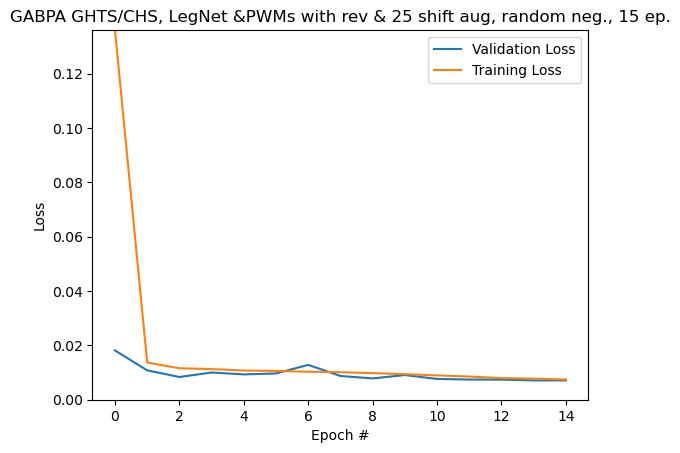

In [8]:
ax = plt.axes()
ax.set_ylim(0, max(metrics_df['val_loss'].max(), metrics_df['train_loss'].max()))
plt.plot(metrics_df['epoch'], metrics_df['val_loss'], label='Validation Loss')
plt.plot(metrics_df['epoch'], metrics_df['train_loss'], label='Training Loss')
plt.title('%s, %s' % (run_info, mod_info))
plt.ylabel('Loss')
plt.xlabel('Epoch #')
plt.legend(loc='upper right')
plt.show()


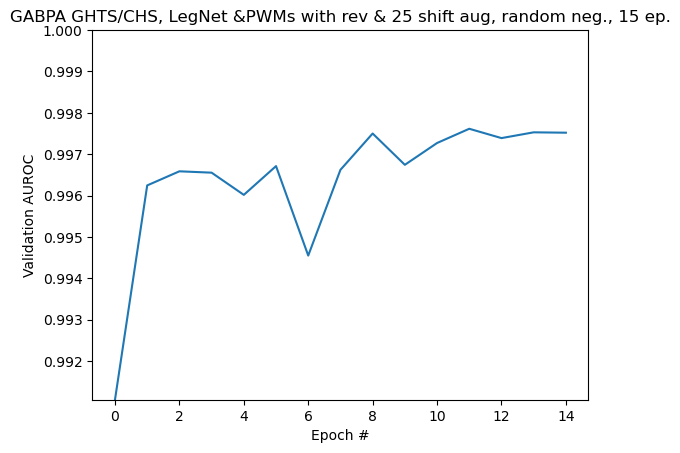

In [9]:
ax = plt.axes()
ax.set_ylim(metrics_df['val_auroc'].min(), 1)
# ax.set_ylim(0.8, 1)
plt.plot(metrics_df['epoch'], metrics_df['val_auroc'])
plt.title('%s, %s' % (run_info, mod_info))
plt.ylabel('Validation AUROC')
plt.xlabel('Epoch #')
plt.show()

In [10]:
preds = ('forw_pred', 'avg_pred', 'rev_pred')
preds_names = {'forw_pred': 'forward', 'rev_pred': 'reverse', 'avg_pred': 'averaged'}
def process_preds_df(path, split, old=False):
    preds_df = pd.read_csv(path % split if not old else path, sep='\t')
    preds_df['avg_pred'] = (preds_df['forw_pred'] + preds_df['rev_pred']) / 2
    return preds_df

In [11]:
def process_multitesting_preds_df(path):
    if isinstance(path, str):
        path = Path(path)
    files = path.rglob('*.tsv')
    for file in files:
        if 'predictions' not in file.stem:
            continue
        name_components = file.stem.split('_')
        preds_df = pd.read_csv(file, sep='\t')
        preds_df['avg_pred'] = (preds_df['forw_pred'] + preds_df['rev_pred']) / 2
        yield (preds_df, name_components[3], name_components[4])

In [12]:
def plot_roc(preds_df, split, negative='', ax=None, title=None, correct=True):
    ax_wasnt_set = ax is None
    ax = plt.axes() if ax_wasnt_set else ax
    ax.axline([0, 0], [1, 1], linewidth=2, color='grey', linestyle=':')
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    title = f'ROC on {run_info}, {mod_info} [{split} {negative}]' if title is None else title
    ax.set_title(title)
        
    for pred in preds:
        fpr, tpr, _ = metrics.roc_curve(preds_df['class_'], preds_df[pred])
        auc = metrics.roc_auc_score(preds_df['class_'], preds_df[pred])
        if correct:
            auc_correct = calcs['auROC'].score(preds_df[pred], preds_df['class_'])
            print('ROC', pred, auc_correct)

        ax.plot(fpr, tpr, label=f'{preds_names[pred]}, AUC = {auc:.3}')
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.legend(loc='lower right')
    if ax_wasnt_set:
        plt.show()
    
def plot_pr(preds_df, split, negative='', ax=None, title=None, correct=True):
    ax_wasnt_set = ax is None
    ax = plt.axes() if ax_wasnt_set else ax
    # ax.axline([0, 0], [1, 1], linewidth=2, color='grey', linestyle=':')
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    title = f'PR on {run_info}, {mod_info} [{split} {negative}]' if title is None else title
    ax.set_title(title)
        
    for pred in preds:
        precision, recall, _ = metrics.precision_recall_curve(preds_df['class_'], preds_df[pred])
        pr = metrics.average_precision_score(preds_df['class_'], preds_df[pred])
        if correct:
            pr_correct = calcs['auPRC'].score(preds_df[pred], preds_df['class_'])
            print('PR', pred, pr_correct)

        ax.plot(recall, precision, label=f'{preds_names[pred]}, PR = {pr:.3}')
        ax.set_xlabel('Recall')
        ax.set_ylabel('Precision')
        ax.legend(loc='lower right')
        
    if ax_wasnt_set:
        plt.show()

In [13]:
try:
    for split in ('valid', 'test'):
        print(f'{split:-^86s}')
        preds_df = process_preds_df(path_to_preds, split)
        plot_roc(preds_df, split)
        plot_pr(preds_df, split)
        g = sns.displot(preds_df, x="avg_pred", hue="class_", kind="kde", common_norm=False)
        plt.title(f'avg_pred distribution on {run_info}, {mod_info} [{split}]')
        plt.show()
        print('')
except:
    pass  
        

----------------------------------------valid-----------------------------------------


In [14]:
try:
    for split in ('test',):
        print(f'{split:-^86s}')
        preds_df = process_preds_df(path_to_preds, split, old=True)
        plot_roc(preds_df, split)
        plot_pr(preds_df, split)
        g = sns.displot(preds_df, x="avg_pred", hue="class_", kind="kde", common_norm=False)
        plt.title(f'avg_pred distribution on {run_info}, {mod_info} [{split}]')
        plt.show()
        print('')
except:
    pass  

-----------------------------------------test-----------------------------------------


[column names on plot](https://stackoverflow.com/questions/45758761/adding-title-to-the-column-of-subplot-below-suptitle)

*************inside**************************random*************

*************cross***************************random*************

*************inside**************************shades*************

*************cross**************************foreigns************

*************cross***************************shades*************

*************inside*************************foreigns************



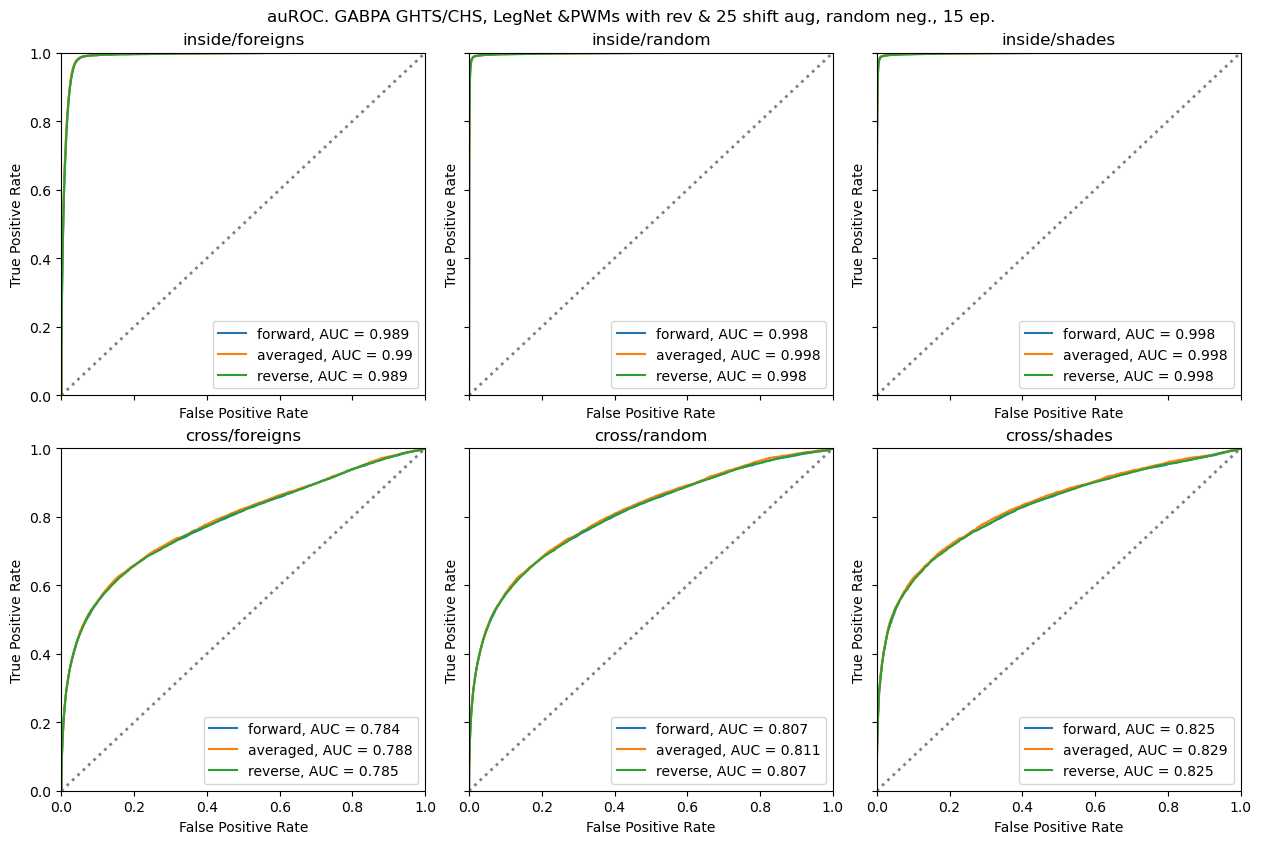

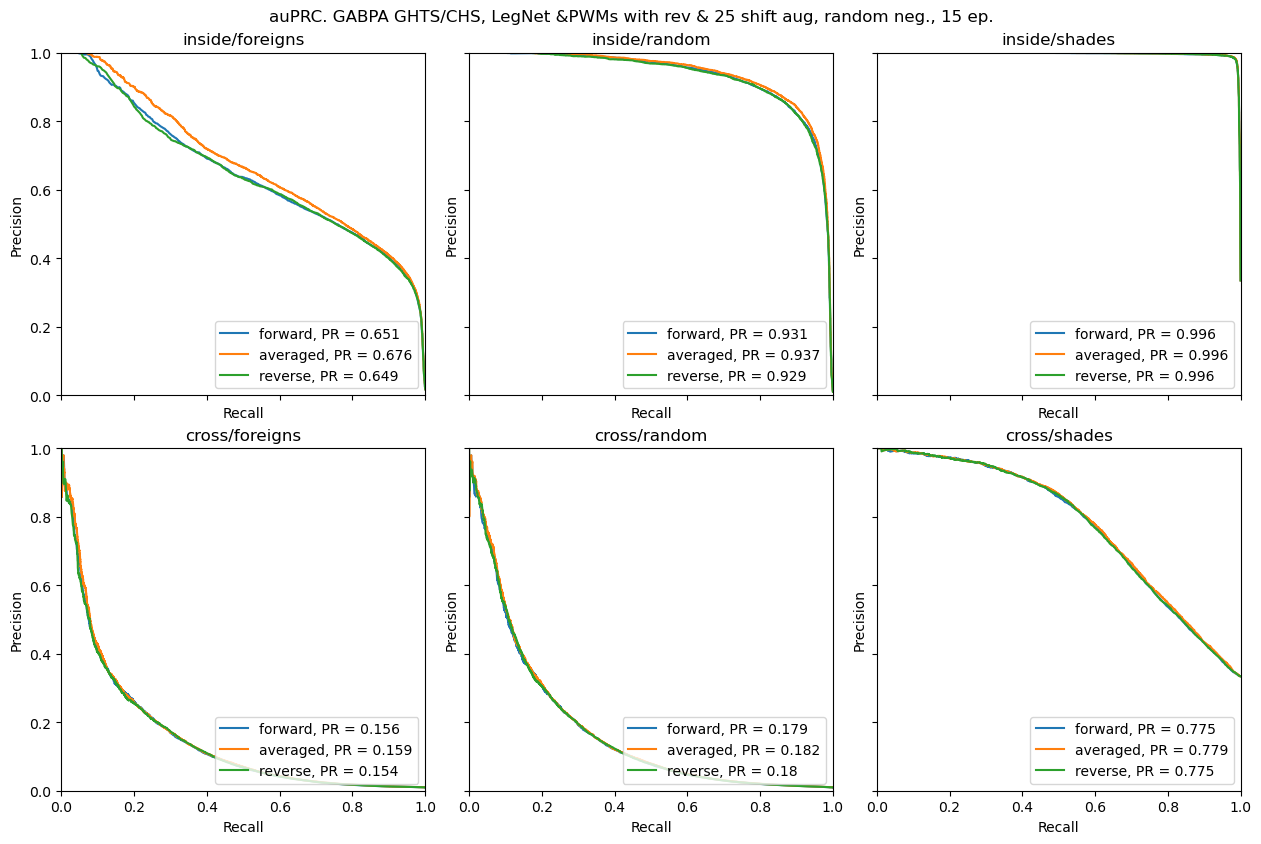

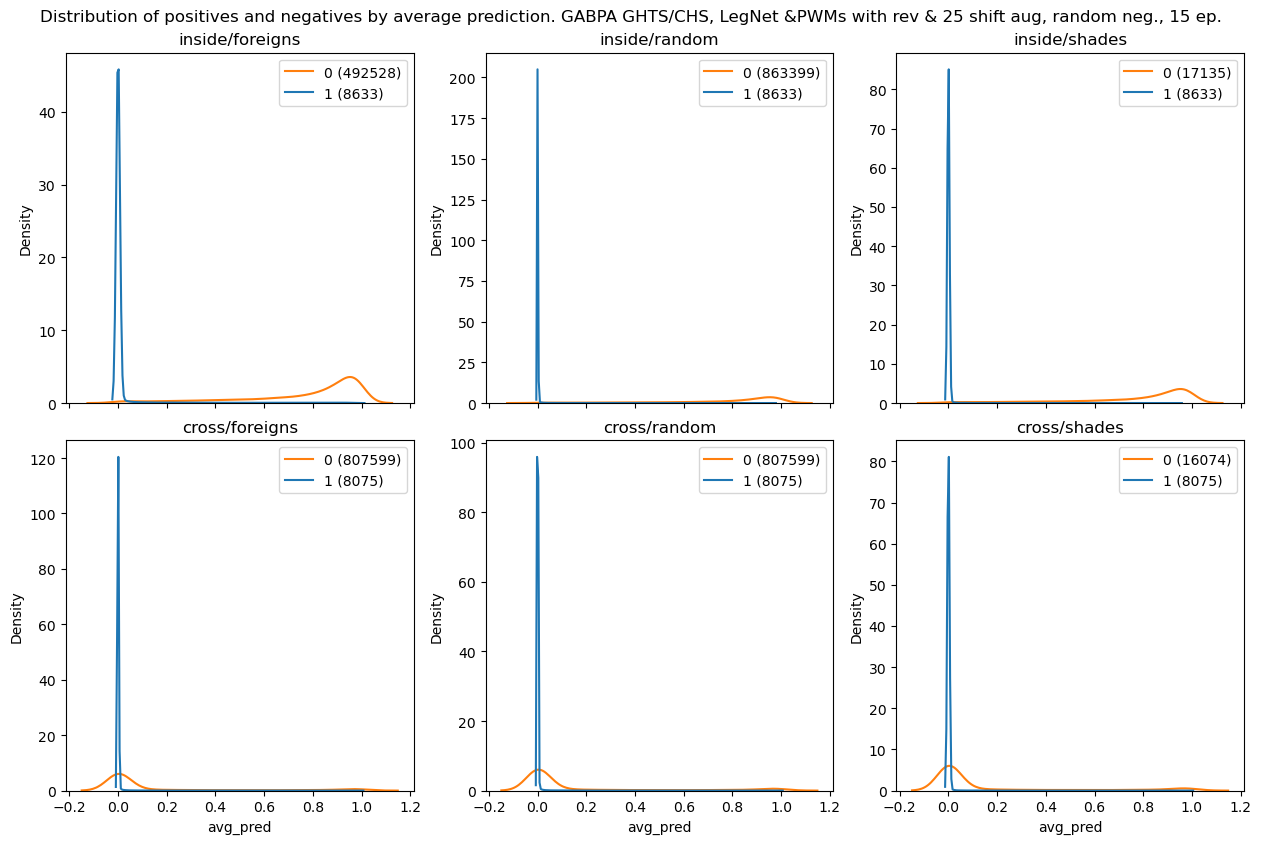

In [15]:
figsize = [x / 1.2 for x in (15, 10)]

fig_roc, axs_roc = plt.subplots(2, 3, figsize=figsize, layout='constrained',
                                sharex=True, sharey=True)
fig_roc.suptitle(f'auROC. {run_info}, {mod_info}')
fig_pr, axs_pr = plt.subplots(2, 3, figsize=figsize, layout='constrained',
                              sharex=True, sharey=True)
fig_pr.suptitle(f'auPRC. {run_info}, {mod_info}')
fig_distr, axs_distr = plt.subplots(2, 3, figsize=figsize, layout='constrained',
                                    sharex=True)
fig_distr.suptitle(f'Distribution of positives and negatives by average prediction. {run_info}, {mod_info}')
def get_ax(axs, split, negative):
    splits_int = {
        'inside': 0,
        'cross': 1
    }
    negatives_int = {
        'foreigns': 0,
        'random': 1,
        'shades': 2
    }
    split_int = splits_int[split]
    negative_int = negatives_int[negative]
    return axs[split_int, negative_int]

def get_title(split, negative):
    # return f'{split}-experiment, {negative} as negatives'
    return f'{split}/{negative}'

try:
    for preds_df, split, negative in process_multitesting_preds_df(path_to_preds):
        print(f'{split:*^32s}{negative:*^32s}')
        plot_roc(preds_df, split, negative, ax=get_ax(axs_roc, split, negative), title=get_title(split, negative), correct=False)
        plot_pr(preds_df, split, negative, ax=get_ax(axs_pr, split, negative), title=get_title(split, negative), correct=False)
        dist_ax = get_ax(axs_distr, split, negative)
        g = sns.kdeplot(preds_df, x="avg_pred", hue="class_", common_norm=False, ax=dist_ax)
        dist_ax.set_title(get_title(split, negative))
        dist_ax.legend(labels = [f'{x} ({n})' for x, n in preds_df['class_'].value_counts().items()])
        # plt.show()
        print('')
except Exception as ex:
    raise ex
plt.show()